In [118]:
%matplotlib inline
import os,sys
import matplotlib
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import csv
import pandas as pd
import sfdmap
import extinction
from astropy import units as u
import math
import pylatex

# pyqsofit
from scipy import interpolate

# for SDSS SQL queries
import mechanize
from io import BytesIO

import glob,timeit

#sys.path.append('/Users/runnojc1/Software/py/pyspeckit')
import pyspeckit
from pyspeckit.spectrum.models.inherited_gaussfitter import gaussian
from pyspeckit.specwarnings import PyspeckitWarning
from astropy.table import Table
from scipy.interpolate import interp1d

# Data

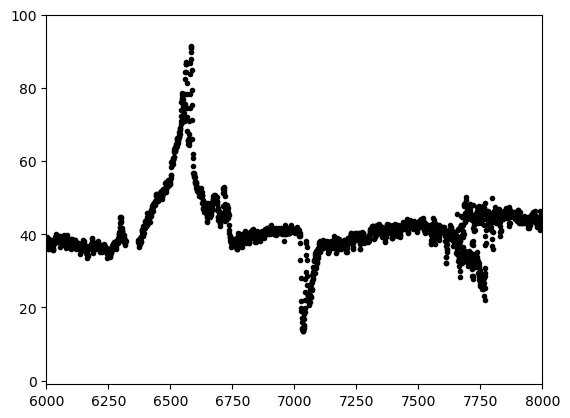

In [119]:
file_path = 'HET/combined_spectrum_20230113_0000022_exp01.fits'

t = Table.read(file_path)
t.sort('Wavelength')

z = 0.081
wl = t['Wavelength']/(1+z)
flux = t['F_lambda'] * (10**17)
err = t['e_F_lambda']

flux_lim = np.where(flux>0)[0]
wl=wl[flux_lim]
flux=flux[flux_lim]
err=err[flux_lim]

#wl_lim = np.where((wl>5900)&(wl<6950))
#wl=wl[wl_lim]
#flux=flux[wl_lim]
#err=err[wl_lim]

mask1 = np.where((wl<6320)|(wl>6370))
wl=wl[mask1]
flux=flux[mask1]
err=err[mask1]

plt.plot(wl, flux, '.k')
plt.xlim(6000, 8000)
plt.ylim(-1, 100)
plt.show()

# Correction

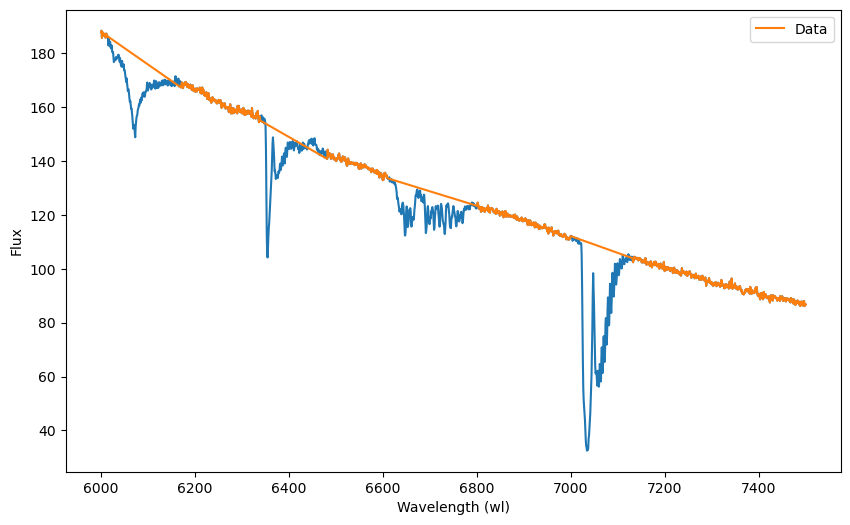

In [120]:
#file_name = 'bundle_20230529_standards/combined_spectrum_20230112_0000009_exp01.fits'
file_name = 'bundle_20230529_standards/spectrum_20230112_0000010_exp01_red.fits'
hdul = fits.open(file_name)
data = hdul[0].data
hdr = hdul[0].header

z = 0.081

wl = data[0]
wl = wl/(1+z)
flux = data[1] *(10**16)
err = data[2]

mask0 = np.where((wl>6000) & (wl < 7500)) 
wl_o = wl[mask0]
flux_o = flux[mask0]
err_o = err[mask0]

mask1 = np.where((wl_o < 6015) | (wl_o > 6170)) 
wl = wl_o[mask1]
flux = flux_o[mask1]
err = err_o[mask1]

mask2 = np.where((wl < 6340) | (wl > 6480)) 
wl = wl[mask2]
flux = flux[mask2]
err = err[mask2]

mask3 = np.where((wl < 6610) | (wl > 6800)) 
wl = wl[mask3]
flux = flux[mask3]
err = err[mask3]

mask4 = np.where((wl < 7000) | (wl > 7130)) 
wl = wl[mask4]
flux = flux[mask4]
err = err[mask4]

plt.figure(figsize=(10, 6))
plt.plot(wl_o, flux_o)
plt.plot(wl, flux, label='Data')  # Original data

#plt.plot(wl_fit, flux_fit-flux_o, label='Best fit curve')  # Fitted curve
plt.xlabel('Wavelength (wl)')
plt.ylabel('Flux')
plt.legend()
plt.show()

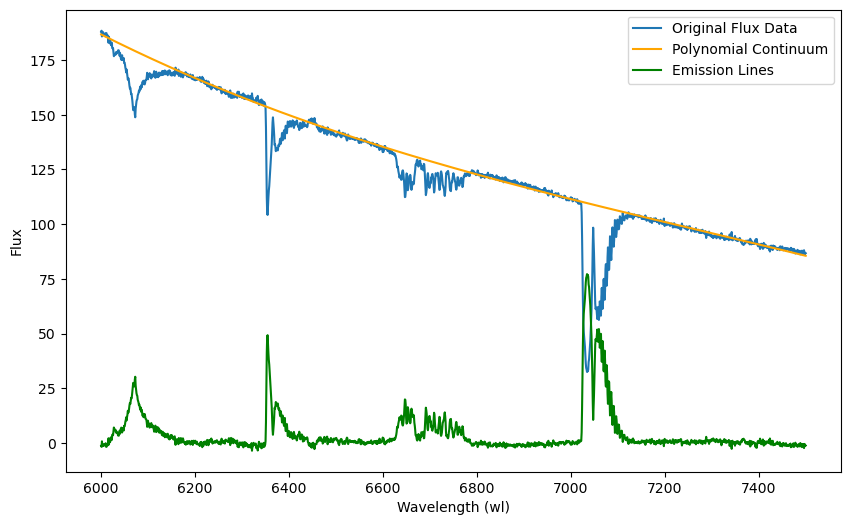

In [121]:
degree = 3
coefficients = np.polyfit(wl, flux, degree)
polynomial_continuum = np.poly1d(coefficients)(wl_o)
standard_flux = polynomial_continuum - flux_o
standard_wl = wl_o


plt.figure(figsize=(10, 6))
plt.plot(wl_o, flux_o, label='Original Flux Data')
plt.plot(wl_o, polynomial_continuum, label='Polynomial Continuum', color='orange')
plt.plot(standard_wl, standard_flux, label='Emission Lines', color='green')
plt.xlabel('Wavelength (wl)')
plt.ylabel('Flux')
plt.legend()
plt.show()

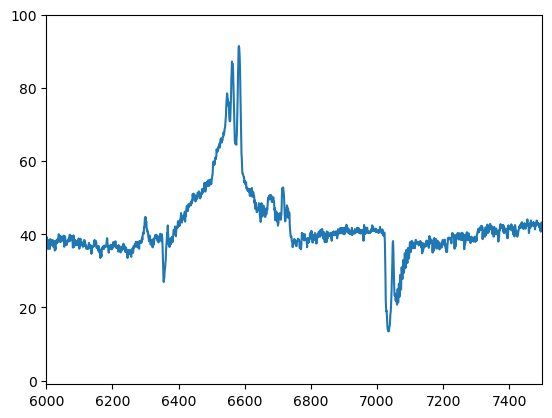

1715


In [205]:
file_path = 'HET/combined_spectrum_20230113_0000022_exp01.fits'

t = Table.read(file_path)
t.sort('Wavelength')

z = 0.081
wl = t['Wavelength']/(1+z)
flux = t['F_lambda'] * (10**17)
err = t['e_F_lambda'] * (10**17)

flux_lim = np.where(flux>0)[0]
source_wl=wl[flux_lim]
source_flux=flux[flux_lim]
source_err=err[flux_lim]

wl_lim = np.where((source_wl>6000)&(source_wl<7500))
source_wl=source_wl[wl_lim]
source_flux=source_flux[wl_lim]
source_err=source_err[wl_lim]


plt.plot(source_wl, source_flux)
plt.xlim(6000, 7500)
plt.ylim(-1, 100)
plt.show()

print(len(source_flux))

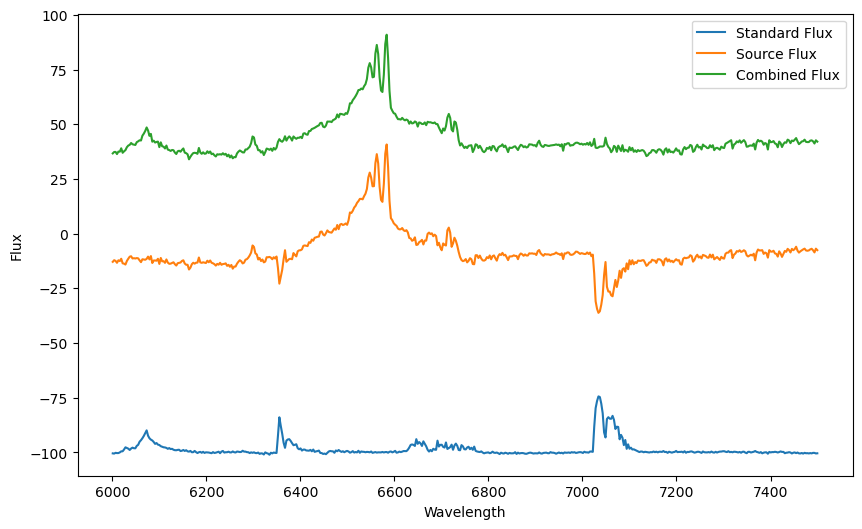

In [206]:
common_wl = np.linspace(min(min(source_wl), min(standard_wl)), max(max(source_wl), max(standard_wl)), num=500)

interp_func1 = interp1d(standard_wl, standard_flux, kind='cubic', bounds_error=False, fill_value='extrapolate')
interp_func2 = interp1d(source_wl, source_flux, kind='cubic', bounds_error=False, fill_value='extrapolate')
interp_func3 = interp1d(source_wl, source_err, kind='cubic', bounds_error=False, fill_value='extrapolate')

interpolated_flux1 = interp_func1(common_wl)
interpolated_flux2 = interp_func2(common_wl)
interpolated_err = interp_func3(common_wl)

combined_flux = interpolated_flux1/3 + interpolated_flux2
corrected_flux =  interpolated_flux2 - interpolated_flux1


source_err = interpolated_err

plt.figure(figsize=(10, 6))
plt.plot(common_wl, interpolated_flux1/3-100, label="Standard Flux")
plt.plot(common_wl, interpolated_flux2-50, label="Source Flux")
plt.plot(common_wl, combined_flux, label='Combined Flux')
#plt.plot(common_wl, source_err)
plt.xlabel('Wavelength')
plt.ylabel('Flux')
plt.legend()
plt.show()


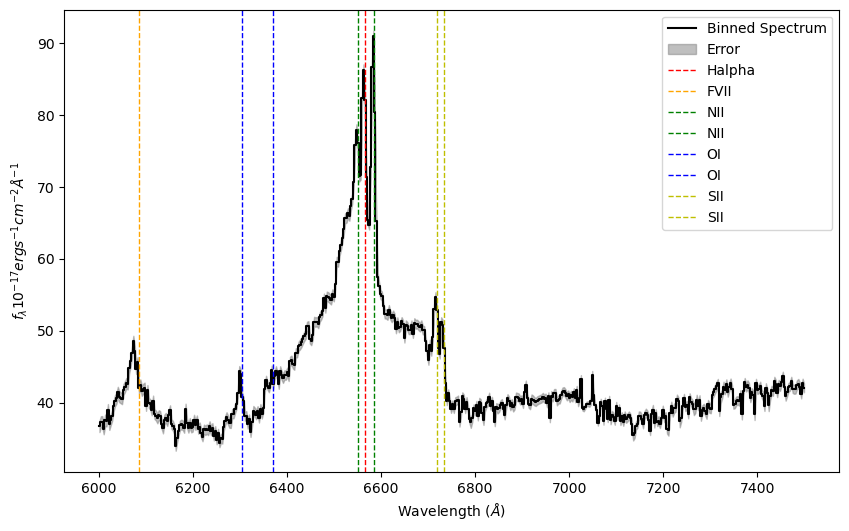

In [224]:
z = 0.081


bin_width = 1

bins = np.arange(min(common_wl), max(common_wl) + bin_width, bin_width)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

indices = np.digitize(common_wl, bins)

binned_wl = []
binned_flux = []
binned_flux_err = []


for i in range(1, len(bins)):
    in_bin = indices == i
    if np.any(in_bin):
        binned_wl.append(np.mean(common_wl[in_bin]))
        binned_flux.append(np.mean(combined_flux[in_bin]))
        binned_flux_err.append(np.mean(source_err[in_bin]))

    else:
        pass

binned_wl = np.array(binned_wl)
binned_flux = np.array(binned_flux)
binned_flux_err = np.array(binned_flux_err)

plt.figure(figsize=(10, 6))
plt.plot(binned_wl, binned_flux, label='Binned Spectrum', color="black", drawstyle='steps-mid')
plt.fill_between(binned_wl, binned_flux - binned_flux_err, binned_flux + binned_flux_err, color='gray', alpha=0.5, label='Error')
plt.axvline(x=6564.93, color='r', linestyle='--', linewidth=1, label="Halpha")
plt.axvline(x=6085.90, color='orange', linestyle='--', linewidth=1, label="FVII")
plt.axvline(x=6551.06, color='g', linestyle='--', linewidth=1, label="NII")
plt.axvline(x=6585.64, color='g', linestyle='--', linewidth=1, label="NII")
plt.axvline(x=6370, color='b', linestyle='--', linewidth=1, label="OI")
plt.axvline(x=6303, color='b', linestyle='--', linewidth=1, label="OI")
plt.axvline(x=6719, color='y', linestyle='--', linewidth=1, label="SII")
plt.axvline(x=6734, color='y', linestyle='--', linewidth=1, label="SII")
plt.xlabel("Wavelength ($\AA$)")
plt.ylabel("$f_{\lambda} 10^{-17} erg s^{-1} cm^{-2} \AA^{-1}$")
#plt.xlim(1000, 1650)
#plt.ylim(-100, 400)
plt.legend()
plt.show()

## Functions

In [225]:
def kms_to_ang(dv,w0):
    """
    Convert a width in km/s to A.
    """
    c = 2.99792458e5 # km/s
    dlam = (dv/c)*w0
    return dlam

In [226]:
def powerlaw(x, scale, power):
    """
    Defines a power law

    Returns
    -------
    scale * x**power
    """
    return scale*(x/1000.)**-power

In [227]:
def gaussian(xarr,amplitude,cent,fwhm,normalized=False,return_components=False,return_hyperfine_components=False):
    """
    Returns a 1-dimensional gaussian of form
    A*np.exp(-(x-dx)**2/(2*w**2))

    Area is sqrt(2*pi*sigma^2)*amplitude - i.e., this is NOT a normalized
    gaussian, unless normalized=True in which case A = Area
    
    Parameters
    ----------
    xarr : np.ndarray
        array of x values
    amplitude : float
        Amplitude of the Gaussian, i.e. its peak value, unless
        normalized=True then A is the area of the gaussian
    cent : float
        Center or "shift" of the gaussian same units as xarr
    fwhm : float
        Full width at half maximum of the Gaussian in km/s
    return_components : bool
        dummy variable; return_components does nothing but is required by all
        fitters
    return_hyperfine_components : bool
        dummy variable; does nothing but is required by all
        fitters
    normalized : bool
        Return a normalized Gaussian?
    """ 
    fwhm = kms_to_ang(fwhm,cent)
    if fwhm == 0:
        return np.nan
    elif fwhm < 0:
        warnings.warn("Negative width in Gaussian: {0}.".format(fwhm),
                      PyspeckitWarning)

    width = fwhm/np.sqrt(8*np.log(2))
    xarr = np.array(xarr) # make sure xarr is no longer a spectroscopic axis
    model = amplitude*np.exp(-(xarr-cent)**2/(2.0*width**2))
    if normalized:
        return model / (np.sqrt(2*np.pi) * width**2)
    else:
        return model

In [300]:
def optical_agn_spectrum(wave_to_fit,pl_s,pl_e,\
                         sii1_f,sii1_cent,sii1_fwhm,\
                         sii2_f,sii2_cent,sii2_fwhm,\
                         oi1_f,oi1_cent,oi1_fwhm,\
                         oi2_f,oi2_cent,oii2_fwhm,\
                         nii1_f,nii1_cent,nii1_fwhm,\
                         nii2_f,nii2_cent,nii2_fwhm,\
                         halpha1_f,halpha1_cent,halpha1_fwhm,\
                         halpha2_f,halpha2_cent,halpha2_fwhm,\
                         halpha3_f,halpha3_cent,halpha3_fwhm,\
                         return_components=False,return_hyperfine_components=False):
    """
    Calculates a full optical AGN spectral model.
    """
    
    #x = wave_to_fit.to_value()
    x = np.array(wave_to_fit)
    y = np.zeros_like(x)
    
    # powerlaw
    pl = powerlaw(x,pl_s,pl_e)      

    # broad [S II] - 6718.85 & 6733.72
    sii1 = gaussian(x,sii1_f,sii1_cent,sii1_fwhm,normalized=False)
    sii2 = gaussian(x,sii2_f,sii2_cent,sii2_fwhm,normalized=False)
    
    oi1 = gaussian(x,oi1_f,oi1_cent,oi1_fwhm,normalized=False)
    oi2 = gaussian(x,oi2_f,oi2_cent,oi2_fwhm,normalized=False)
    
    nii1 = gaussian(x,nii1_f,nii1_cent,nii1_fwhm,normalized=False)
    nii2 = gaussian(x,nii2_f,nii2_cent,nii2_fwhm,normalized=False)
    
    # narrow and broad halpha line
    halpha1 = gaussian(x,halpha1_f,halpha1_cent,halpha1_fwhm,normalized=False)
    halpha2 = gaussian(x,halpha2_f,halpha2_cent,halpha2_fwhm,normalized=False)
    halpha3 = gaussian(x,halpha3_f,halpha3_cent,halpha3_fwhm,normalized=False)

    y = pl + sii1 + sii2 + halpha1 + halpha2 + halpha3 + nii1 + nii2 + oi1 + oi2
    
    if return_components:
        y = {'model':y,\
             'pl':pl,\
            'sii1':sii1,\
             'sii2':sii2,\
             'oi1':oi1,\
             'oi2':oi2,\
             'nii1':nii1,\
            'nii2':nii2,\
            'halpha1':halpha1,\
            'halpha2':halpha2,\
            'halpha3':halpha3} 
    
    return y

In [301]:
def pl_fitter(order=1):
    """
    Generator for powerlaw fitter class
    """

    myclass =  pyspeckit.models.model.SpectralModel(plaw, 2,
            parnames=['scale','power'], 
            parlimited=[(False,False),(False,False)], 
            parlimits=[(0,0),(0,0)], 
            shortvarnames=('S','P')
            )
    myclass.__name__ = "pl"
    
    return myclass

In [302]:
def template_fitter(wave,templates,scale_factor,index,shift):
    '''
    given a series of templates (like stellar models by age or Fe II templates by convolution width),
    returns a spectrum interpolated between template spectra and scaled.
    Spectrum is also interpolated onto the wavelength vector of the observed data.
    
    params:
        wave - wavelength vector of observed data
        templates - 2D numpy array of shape (numpoints,num_templates+1), where 1st column is wavelength, subsequent columns are templates
        index - selected index within templates [0-num_templates]. Float, will interpolate between templates when index!=int
        scale_factor - multiplicative scale factor for spectrum
    '''
    num_templates=templates.shape[1]-1
    numpoints=templates.shape[0]
    
    if shift>=0:
        wave_temp=templates[:,0]*(1+shift)
    else:
        wave_temp=templates[:,0]/(1+shift)
    flux_temp=templates[:,1:]
    
    # Perform interpolation between templates
    if index==num_templates-1:
        spectrum=templates[:,-1]
    else:
        lower_idx=int(math.floor(index)+1) #+1 because 0th index is wavelength column
        lower_spectrum=templates[:,lower_idx] # this means lower in index, not necessarily in flux
        
        upper_idx=lower_idx+1
        upper_spectrum=templates[:,upper_idx]
        
        weight=(index+1)-lower_idx #1=choose upper spectrum value, 0=choose lower spectrum value, 0.5=choose midpoint
        
        distances=upper_spectrum-lower_spectrum # array of distances between selected spectra
        
        spectrum=lower_spectrum+(weight*distances)
        
    # Perform scaling
    scaled_spectrum=spectrum*scale_factor
    
    # interpolate spectrum onto wavelength vector of data
    final_spectrum=np.interp(wave,wave_temp,scaled_spectrum)

    return final_spectrum

In [303]:
def optical_agn_fitter(order=1):
    """
    Generator for powerlaw fitter class
    """

    myclass =  pyspeckit.models.model.SpectralModel(optical_agn_spectrum, 29,
            parnames=['pl_s','pl_e',\
                     'sii1_f','sii1_cent','sii1_fwhm',\
                      'sii2_f','sii2_cent','sii2_fwhm',\
                      'oi1_f','oi1_cent','oi1_fwhm',\
                      'oi2_f','oi2_cent','oi2_fwhm',\
                      'nii1_f','nii1_cent','nii1_fwhm',\
                     'nii2_f','nii2_cent','nii2_fwhm',\
                     'halpha1_f','halpha1_cent','halpha1_fwhm',\
                     'haplha2_f','halpha2_cent','halpha2_fwhm',\
                     'haplha3_f','halpha3_cent','halpha3_fwhm'], 
            parlimited=[(False,False),(False,False),\
                       (False,False),(False,False),(False,False),\
                        (False,False),(False,False),(False,False),\
                        (False,False),(False,False),(False,False),\
                        (False,False),(False,False),(False,False),\
                        (False,False),(False,False),(False,False),\
                       (False,False),(False,False),(False,False),\
                       (False,False),(False,False),(False,False),\
                        (False,False),(False,False),(False,False),\
                       (False,False),(False,False),(False,False),], 
            parlimits=[(0,0),(0,0),\
                      (0,0),(0,0),(0,0),\
                       (0,0),(0,0),(0,0),\
                       (0,0),(0,0),(0,0),\
                       (0,0),(0,0),(0,0),\
                      (0,0),(0,0),(0,0),\
                       (0,0),(0,0),(0,0),\
                       (0,0),(0,0),(0,0),\
                      (0,0),(0,0),(0,0),\
                      (0,0),(0,0),(0,0)]
            )
    myclass.__name__ = "optagn"
    
    return myclass

In [304]:
def plot_optical_agn_fit(wave,flux,model,wavemin,wavemax,ymin,ymax,xlabel,ylabel,plotfile,HARDCOPY=False,SHOW=True):
    
    sii1 = model['sii1']
    sii2 = model['sii2']
    oi1 = model['oi1']
    oi2 = model['oi2']
    halpha1 = model['halpha1']
    halpha2 = model['halpha2']
    halpha3 = model['halpha3']
    nii1 = model['nii1'] 
    nii2 = model['nii2']
    
    
    fig = plt.figure(figsize=(18, 6))
    ax  = plt.axes()
    ax.plot(wave,flux,drawstyle='steps-mid',color='black')
    ax.plot(wave,model['model'],color=pink,lw=2)
    ax.plot(wave,model['pl'],color=royal_blue)
    ax.plot(wave,sii1,color=green)
    ax.plot(wave,sii2,color=green)
    ax.plot(wave,halpha1,color=blood_orange)
    ax.plot(wave,halpha2,color=blood_orange)
    ax.plot(wave,halpha3,color=blood_orange)
    ax.plot(wave,nii1,color=dark_orange)
    ax.plot(wave,nii2,color=dark_orange)
    ax.set_xlim(wavemin,wavemax)
    ax.set_ylim(ymin,ymax)
    ax.set_xlabel(xlabel,size=24)
    ax.set_ylabel(ylabel,size=24)
    plt.tight_layout()
    if HARDCOPY: fig.savefig(plotfile+'_fullfit.pdf', format='pdf')
    if SHOW: plt.show()
    plt.close(fig)
    
    #fig = plt.figure(figsize=(8, 6))
    #ax  = plt.axes()
    #ax.plot(wave,flux,drawstyle='steps-mid',color='black')
    #ax.plot(wave,model['model'],color=indian_red,lw=2)
    #ax.plot(wave,model['pl'],color=royal_blue)
    #ax.set_xlim(4700,5100)
    #ax.set_ylim(ymin,ymax)
    #ax.set_xlabel(xlabel,size=24)
    #ax.set_ylabel(ylabel,size=24)
    #plt.tight_layout()  
    #if HARDCOPY: fig.savefig(plotfile+'_Hbfit.pdf', format='pdf')
    #if SHOW: plt.show()
    #plt.close(fig)
    #
    #fig = plt.figure(figsize=(8, 6))
    #ax  = plt.axes()
    #ax.plot(wave,flux,drawstyle='steps-mid',color='black')
    #ax.plot(wave,model['model'],color=indian_red,lw=2)
    #ax.plot(wave,model['pl'],color=royal_blue)
    #ax.set_xlim(3715,4450)
    #ax.set_ylim(ymin,ymax)
    #ax.set_xlabel(xlabel,size=24)
    #ax.set_ylabel(ylabel,size=24)
    #plt.tight_layout()  
    #if HARDCOPY: fig.savefig(plotfile+'_SBfit.pdf', format='pdf')
    #if SHOW: plt.show()
    #plt.close(fig)

## Setup for plotting

In [305]:
# SETUP 
##############################################################
##############################################################
fontfamily = 'Times New Roman'
matplotlib.rcParams['font.family'] = fontfamily
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble']=r"\usepackage{amsmath}"
plt.rc('xtick.major',pad=2)
plt.rc('ytick.major',pad=2)
plt.rc('xtick.minor',pad=2)
plt.rc('ytick.minor',pad=2)
plt.rc('xtick', labelsize=24)
plt.rc('ytick', labelsize=24)
plt.rc('font',size=24,weight='bold')
plt.rcParams['axes.labelweight'] = 'bold'

blood_orange = [204/255,17/255,0/255]
indian_red = [176/255,23/255,31/255]
indian_red = [200/255,23/255,31/255]
green = [0/255,205/255,0/255]
dark_orange = [255/255,127/255,0/255]
goldenrod = [255/255,193/255,37/255]
midnight_blue = [25/255,25/255,112/255]
transparent_blue = [138/255,181/255,220/255]
gray = [130/255,130/255,130/255]
dark_gray = [50/255,50/255,50/255]
salmon = [250/255,128/255,114/255]
royal_blue = [0/255,0/255,200/255]
turquoise  = [0/255,204/255,204/255]
cyan  = [0/255,255/255,255/255]
pink = [255/255,0/255,127/255]
med_pink = [191/255, 0/255, 96/255]
dark_pink = [128/255, 0/255, 64/255]

## Fit parameters from a rough spectral decomposition

Do a very rough spectral decomposition to the H$\beta$ region in order to get some guesses for starting parameters in this regime.

This creates a "continuum subtracted" spectrum by subtracting a hardcoded value, then fits Gaussians and saves their best-fit values to use as a starting guess later. It won't work on any other spectrum because of the continuum subtraction.

In [306]:
flux = binned_flux
lam = binned_wl
err = binned_flux_err


In [307]:
sii1 = 6718.85
sii2 = 6733.72
halpha = 6564.93
nii1 = 6551.06
nii2 = 6585.64
oi2 = 6370.46
oi1 = 6303.05

sii2_off = sii2/sii1
nii1_off = nii1/sii1
nii2_off = nii2/sii1
oi1_off = oi1/sii1
oi2_off = oi2/sii1
halpha_off = halpha/sii1


c = 2.99e5 # km/s

In [308]:
guesses = [5,0,\
          10, sii1, 800,\
           10, sii2, 800,\
           10, oi1, 800,\
           10, oi2, 800,\
          10, nii1, 800,\
           10, nii2, 800,\
          10, halpha, 800,\
          5, halpha, 3000,\
          5, halpha, 1000,]
           
tied = ['','',\
       '', '', '',\
        '', 'p[3] * {0}'.format(sii2_off), 'p[4]',\
        '', 'p[3] * {0}'.format(oi1_off), 'p[4]',\
        '', 'p[3] * {0}'.format(oi2_off), 'p[4]',\
       '', 'p[3] * {0}'.format(nii1_off), 'p[4]',\
        '', 'p[3] * {0}'.format(nii2_off), 'p[4]',\
       '', 'p[3] * {0}'.format(halpha_off), 'p[4]',\
       '', '', '',\
       '', '', '',]

step = [0.5, 0.05,\
       0.5, 0.1, 5,\
        0.5, 0.1, 5,\
        0.5, 0.1, 5,\
        0.5, 0.1, 5,\
       0.5, 0.1, 5,\
        0.5, 0.1, 5,\
        0.5, 0.1, 5,\
       0.5, 0.1, 5,\
       0.5, 0.1, 5]

fixed = [0,0,\
        0,0,0,\
         0,0,0,\
         0,0,0,\
         0,0,0,\
        0,0,0,\
         0,0,0,\
        0,0,0,\
         0,0,0,\
        0,0,0]

In [309]:
print(len(guesses))

29


In [310]:
# this actually does the fit after resetting the spectrum
spec = pyspeckit.Spectrum(data=flux,xarr=lam,error=err)
spec.unit = 'erg s$^{-1}$ cm$^{-2}$ $\\AA^{-1}$'
spec.xarr.set_unit = u.angstrom #'$\\AA$'
spec.xarr.xtype='angstrom'
spec.Registry.add_fitter('opticalagn',optical_agn_fitter(),29)
spec.specfit.selectregion(xmin=6000,xmax=7000)
spec.specfit(fittype='opticalagn',vheight=False,guesses=guesses,tied=tied,fixed=fixed,parsteps=step,maxiter=500,baseline=False,subtract_baseline=False,quiet=False)

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,334 [pyspeckit.spectrum.interactive]


NameError: name 'oi2_fwhm' is not defined

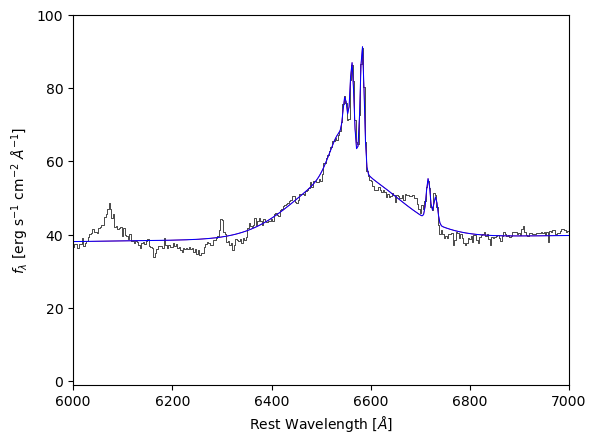

In [298]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
spec.plotter(xmin=6000,xmax=7000,ymin=-1,ymax=100,xlabel='Rest Wavelength [$\AA$]',ylabel="$f_{\lambda}$ [erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$]")
spec.specfit.plot_fit(annotate=False)
spec.specfit.plot_components()
plt.show()

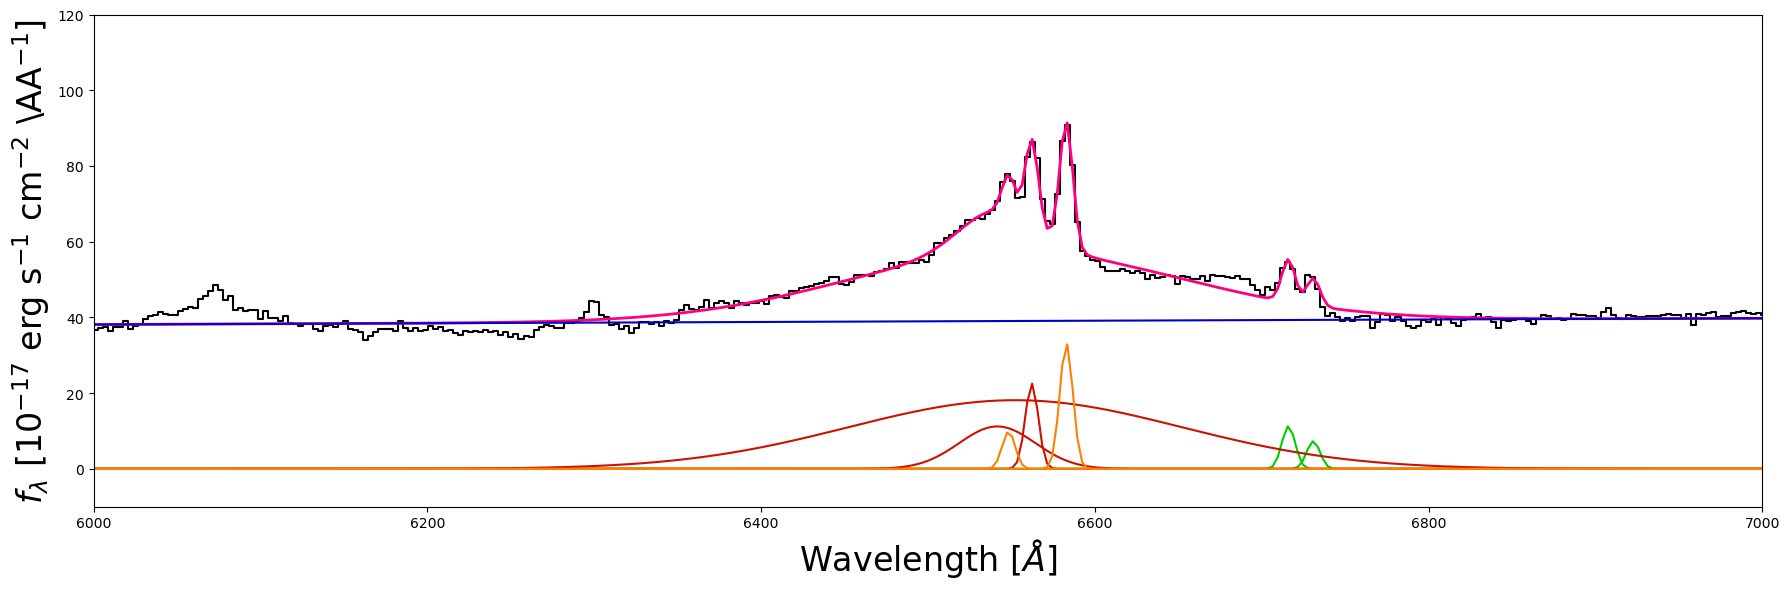

In [299]:
best_model = optical_agn_spectrum(lam,*spec.specfit.parinfo.values,return_components=True)
wavemin = 1000.
wavemax = 1650.
ymin = -100.
ymax = 400.
wave = lam
flux = flux
model = best_model
xlabel = 'Wavelength $[\AA]$'
ylabel = '$f_\lambda$ [10$^{-17}$ erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$]'
plotfile = '../plots/j0950/plots/spec-52509-0902-0498'
HARDCOPY = False
SHOW = True

plot_optical_agn_fit(lam,flux,best_model,6000,7000,-10,120,'Wavelength $[\AA]$',\
                     '$f_\lambda$ [10$^{-17}$ erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$]',\
                     plotfile,HARDCOPY=False,SHOW=True)